# Part 1: Black Box KLVI 

This notebook is the first of a two part series that walks through the key ideas of my thesis. The goal is to allow users to walk through and recreate my main thesis results.

**Thesis Problem: Use alternative divergence measures (aside from the KL divergence) to estimate posterior distributions more accurately for a single factor confirmatory factor analysis model.** 

My thesis investigates whether we can use a generalised divergence measure to perform black box variational inference to solve the problem of variance underestimation. 

The variance underestimation problem is when posteriors estimated using VI (Variational Inference)  **underestimate** the true posterior variance. It occurs whenever we use the typical divergence measure (KL Divergence), in both analytical **and** black-box implementations of VI.

**Notebook Purpose**

This notebook focuses on applying black box KL Variational Inference (KLVI) via reparameterisation gradients to the single factor confirmatory factor analysis model (CFA model), using the classic Holzinger Swineford (1939) dataset.

The notebook has three outcomes:

* **Outline mathematical basis of the thesis**

* **I demonstrate that black box KLVI can be applied to the single CFA model.** 

* **I replicate the finding of variance underestimation via black box KLVI** 
    * We replicate the results of KD Dang, who applied KLVI to the single CFA model via analytical methods rather than black box methods. Dang found that analytical KLVI estimates posterior means accurately, but underestimates true posterior variances. We find the same results hold for black box KLVI.

# Imports and Global Variables

In [4]:
%load_ext autoreload
%autoreload 2
%load_ext tensorboard

In [5]:
from semopy.examples import holzinger39
import torch
from torch.distributions import MultivariateNormal as mvn
import pickle
from dataclasses import asdict

In [6]:
import sys 
sys.path.append('..')
from src.variational_sem import SingleCFAVIModel, VIOptimisationParameters
from src.analytical_variational_inference.analytical_variational_infernce import single_factor_cfa_mfvb
from src.mcmc.mcmc import single_factor_cfa_mcmc
from src.analysis.sampling import sample_from_distribution
from src.analysis.visualisation import plot_credint
from src.helpers import pickle_file, unpickle_file

/Users/vivbear/Documents/data_science_and_ai/variational-inference-single-factor-cfa-thesis/single-cfa-venv-3.10/lib/python3.10/site-packages/rpy2/rinterface/__init__.py:1211: UserWarning: Environment variable "PWD" redefined by R and overriding existing variable. Current: "/", R: "/Users/vivbear/Documents/data_science_and_ai/variational-inference-single-factor-cfa-thesis/notebooks"
  warnings.warn(
/Users/vivbear/Documents/data_science_and_ai/variational-inference-single-factor-cfa-thesis/single-cfa-venv-3.10/lib/python3.10/site-packages/rpy2/rinterface/__init__.py:1211: UserWarning: Environment variable "R_SESSION_TMPDIR" redefined by R and overriding existing variable. Current: "/var/folders/rw/17130_512vz5y5_7d1l60_dh0000gn/T//Rtmpkx2SbX", R: "/var/folders/rw/17130_512vz5y5_7d1l60_dh0000gn/T//Rtmpq4QTZV"
  warnings.warn(
/Users/vivbear/Documents/data_science_and_ai/variational-inference-single-factor-cfa-thesis/single-cfa-venv-3.10/lib/python3.10/site-packages/stan/plugins.py:4: Us

In [ ]:
#GLOBAL VARIABLES 
NON_LATENT_PARAMETERS = ['nu.1', 'nu.2', 'nu.3', 'lam.1', 'lam.2', 'psi.1', 'psi.2', 'psi.3', 'sig2']
SAMPLE_SIZE = 60_000
VI_MODELS_FILEPATH = '../data/vi_models/'

# Introduction - Mathematical Preliminaries 

In this section I will quickly outline the mathematical basis of the thesis.  For more detail the reader should refer to the thesis in its entirety.

## 1. Overview of Bayesian Inference Methods 

One of the central problems of Bayesian inference is how to approximate posterior distributions in a method that is fast, accurate and easily generalized to different probability models. A Bayesian statistical model consists of the following: 

* observed data $\mathbf{x}$, 
* model parameters $\pmb{\theta}$ 
* likelihood distribution ${p(\mathbf{x} | \pmb{\theta})}$
* prior distribution on the model parameters, ${\pi(\pmb{\theta})}$

Bayesian statistical inference is based on estimating the posterior distribution ${p(\pmb{\theta} \, | \, \mathbf{x})}$ which has a concise but usually analytically intractable form:  

$${p(\pmb{\theta} \, | \, \mathbf{x})} = \frac{{p(\mathbf{x} | \pmb{\theta})} \cdot {\pi(\pmb{\theta})}}{p(\mathbf{x})}$$

The gold standard for approximating posteriors is a sampling method called Markov Chain Monte Carlo (MCMC), which unfortunately can be very computationally intensive with high dimensionality parameters. 

## 2. Variational Inference: An Optimisation Problem

As an alternative, Variational Inference (VI) is an **optimisation method** for approximating ${p(\pmb{\theta} \, | \, \mathbf{x})}$, which is potentially faster than MCMC. 

The central idea of VI is to approximate the unknown posterio with a simpler and more tractable distribution ${q^{*}(\pmb{\theta})}$. 

Any VI procedure is comprised of the following ingredients.

We start with our Bayesian model specified by ${p(\mathbf{x} | \pmb{\theta})}$ and ${\pi(\pmb{\theta})}$. Then, we prespecify a family of candidate probability distributions, denoted as $\mathcal{Q}$. Each member of the set $\mathcal{Q}$ is a probability distribution ${q(\pmb{\theta})}$ on the model parameter $\pmb{\theta}$, and has a known, tractable form. From $\mathcal{Q}$, we next find the ${q^{*}(\pmb{\theta})}$ that is **closest** to the unknown posterior.

Closeness is measured by the Kullback Leibler divergence ${\text{KL} ( q(\pmb{\theta}) \: || \: {p(\pmb{\theta} \, | \, \mathbf{x})})}$. 

The optimised distribution ${q^{*}(\pmb{\theta})}$ is then used as a proxy for the posterior. In this way, inference reduces to an optimisation problem: 

$$
    {q^{*}(\pmb{\theta})}= \argmin_ {q(\pmb{\theta})\in \mathcal{Q}} {\text{KL} ( q(\pmb{\theta}) \: || \: \{p(\pmb{\theta} \, | \, \mathbf{x})}
$$

### 2.1 KLVI Objective 

The KL Divergence from a posterior ${p(\pmb{\theta} \, | \, \mathbf{x})}$  to a candidate variational distribution $q(\pmb{\theta})$ is defined as: 
$$
\text{KL}( q \: || \: p) = \int q(\theta) \log \frac{q(\theta)}{p(\theta)} d\theta  \\
= \mathbb{E}_{q_{(\theta)}}\left[  \log  \frac{q(\theta)}{p(\theta)}      \right]
$$

It is not possible to directly evaluate this expression directly and an equivalent KLVI objective is: 

$$
    {q^{*}(\pmb{\theta})}= \argmax_{q(\pmb{\theta}) \in \mathcal{Q}}\left[\text{ELBO}(\pmb{\theta})\right].
$$

The ELBO, or evidence lower bound, is strictly a function of $q$, and is defined as: 

$$
\text{ELBO} := \mathbb{E}_{q(\pmb{\theta})}\left[ \log {p(\mathbf{x} , \pmb{\theta})} - \log q(\pmb{\theta}) \right].
$$


## 3. Thesis Aim: Improve Variational Inference By Varying the Loss Function 

### Problem: Variance Underestimation 

It is a known problem that VI performed by minimising the KL divergence results in posterior estimates that underestimate the true posterior variance.

My thesis tackles this problem by varying or changing the divergence measure that we minimise for. 

## Renyi Divergences 

The Renyi family of $\alpha$ divergences is a generalised family of divergence measures defined on $\alpha >0, \alpha !=1$. As $\alpha$ approaches 1, the Renyi alpha divergence converges to the KL Divergence. The Renyi divergence measure from the posterior $p(\theta)$ to any variational approximation $q(\theta)$ is given by: 

\begin{align}
{    D_{\alpha}[q \:|| \: p]}:= \frac{1}{\alpha - 1}\log \int {p(\theta)}^{1-\alpha} {q(\theta)}^{\alpha}d\theta \qquad \text{for } \alpha \in \mathbb{R}_{>0, \neq1}
\end{align}

## Why use different divergence measures? 

Minimising the KL divergence measure enforces a type of behaviour that is termed in the literature as zero forcing or "mode-seeking" behaviour. Specifically, due to the form of the KL divergence given by

$$
\text{KL}( q \: || \: p) = \int q(\theta) \log \frac{q(\theta)}{p(\theta)} d\theta  \\
= \mathbb{E}_{q_{(\theta)}}\left[  \log  \frac{q(\theta)}{p(\theta)}      \right]
$$, 

the optimised variational distribution ${q^{*}(\pmb{\theta})}$ will tend to be forced to zero whenever  ${p(\pmb{\theta} \, | \, \mathbf{x})} \approx 0$. Therefore, zero forcing behaviour will tend to understimate the posterior support. 

Similarly, minimising the Renyi divergence for any valid $\alpha > 0$ is done in practice by maximising the VR Bound, which is a generalisation of the ELBO and which converges to $\text{ELBO}(q)$ as $\alpha \rightarrow 1$: 

$$\text{VR}_{\alpha}:= {\frac{1}{1-\alpha}\:\mathbb{E}_{q}\left[\left(\frac{{p(\mathbf{x}, \,  \pmb{\theta})}}{{q(\pmb{\theta})}}\right)^{1-\alpha}\right]}$$

### Increased mode seeking or zero forcing behaviour as $\alpha >> 1$

On $\alpha >> 1$, minimising the VR Bound results in an optimised ${q^{*}(\pmb{\theta})}$ that should theoretically result in more and more pronounced zero forcing behaviour. 

### Mass covering behaviour for $\alpha < 1$

Conversely, on $\alpha < 1$ the expression $\left[\frac{{p(\mathbf{x}, \,  \pmb{\theta})}}{{q(\pmb{\theta})}}\right]^{1-\alpha}$ is a decreasing function of $\frac{q(\theta)}{p(\theta)}$, so is reasonable to expect that ${q^{*}(\pmb{\theta})}$  optimised under an $\alpha <1$ routine may exhibit less zero forcing behaviour.

### Generalise optimisation routine to $\alpha < 0$

Technically, $\alpha< 0$ does not define a valid divergence but the VR optimisation objective with $\alpha < 0$ is still well defined. However, there are compelling mathematical arguments for why using an appropriate $\alpha < 0$ may result in some mass covering rather than zero forcing behaviour.

## 4. Implementing Variational Inference: Analytical vs. Black Box methods

The classical way of implementing Variational Inference is via analytical methods, i.e. the optimisation routine can be figured out by pen and paper, requiring model specific derivations. 

### High Level Overview: Black box methods via re-parameterisation gradients 

The more general paradigm that has overtaken the literature is a black box approach for Variational Inference, specifically using re-parameterisation gradients. 

**What is black box VI?**

The "black-box" terminology refers to maximising the VR bound $\text{VR}_{\alpha}(q)$ by performing stochastic gradient ascent by **estimating**, at any given step, the theoretical gradient $\nabla \text{VR}_{\alpha}(q)$ via finite sampling from the known distribution $q$. 

**What is re-parameterisation sampling?**

At a high level, the reparameterisation method for calculating stochastic gradients allows us to approximate the gradient $\nabla \text{VR}_{\alpha}(q)$  by calculating gradients with respect to the individual variational parameters $\phi$ that parameterise the variational family $\mathcal{Q}$. At a high level (see thesis for exact derivations), this means we can approximate the gradient by doing the following: 

 1. Sample a finite K times from the current variational distribution $q(\theta)$, which is parametrised by a specific variational parameter value $\phi$
 2. Evalute the VR bound (or a biased estimator,  see below) for each of the K sampling values and taking the average 
 3. Evaluating the gradient of the averaged VR bound (or a biased estimator of the VR bound) with respect to the variational parameter $\phi$ via the straightforward ```.rsample()``` command in Pytorch.

 ### Precise Implementation - Using the Biased VR Bound 

 Recall that to perform Variational Inference for any $\alpha > 0$, we want to choose ${q^{*}(\pmb{\theta})}$ to maximise the VR-bound given by: 

 $$
 \text{VR}_{\alpha}:= {\frac{1}{1-\alpha}\log \:\mathbb{E}_{q}\left[\left(\frac{{p(\mathbf{x}, \,  \pmb{\theta})}}{{q(\pmb{\theta})}}\right)^{1-\alpha}\right]}
 $$.  

 In practice, the loss function we calculate is a biased but consistent estimator, parameterised by the number of finite samples K that we draw from the variational distribution $q(\theta)$ at optimisation step $t$, and is defined as: 
$$
\begin{align}
    &\hat{\text{VR}_{\alpha}} := \frac{1}{1-\alpha}\log \frac{1}{K}\sum_{i=1}^{i=K}\left[ 
    \left(\frac{{{p(\mathbf{x}, \,  \pmb{\theta_i})}}}{{q(\pmb{\theta_i})}}\right)^{1-\alpha}
    \right] \quad \pmb{\theta_i} \overset{iid}{\sim} q(\pmb{\theta})
\end{align}
$$

To perform stochastic gradient descent, we evaluate the gradient of $\hat{\text{VR}_{\alpha}}(q)$ via reparameterisation sampling.

For the KL divergence, i.e. on $\alpha =1$, note that our estimator is actually unbiased and equal to: 

$$
\begin{align}
    &\hat{\text{VR}_{\alpha=1}} := \frac{1}{K}\sum_{i=1}^{i=K}\left[ 
    \log({{p(\mathbf{x}, \,  \pmb{\theta_i})}}) - \log({{q(\pmb{\theta_i})}})
    \right] \quad \pmb{\theta_i} \overset{iid}{\sim} q(\pmb{\theta})
\end{align}
$$

## 5. Model Choice: Single Factor Confirmatory Factor Analysis Model

In this repo/my thesis we solely focused on a single Bayesian statistical model, the Single Confirmatory Factor Analysis Model. 

These models are used to test the relationship between observed responses and latent or unobserved variables. However, we stress that the VI algorithms we implement in our research are black box: they can be easily applied to more complex structural equation models: the elementary 1 factor CFA model is a convenient starting point.

$$
\mathbf{x}_i | \, \pmb{\nu}, \pmb{\lambda}, \pmb{\eta}_i, \pmb{\psi} \overset{ind}\sim N(\pmb{\nu} + \pmb{\lambda}\pmb{\eta}_i, \: \text{diag}(\pmb{\psi})) \nonumber \\
\pmb{\eta}_i \, | \, \pmb{\sigma^2} \overset{ind}{\sim} N(0, \pmb{\sigma^2}), \quad i = 1, \ldots n, \nonumber \\
\pmb{\lambda}_j \, | \, \pmb{\psi}_j \overset{ind}{\sim} N(\mu_{\lambda}, \sigma^2_{\lambda}\pmb{\psi}_j), \qquad \pmb{\nu}_j \overset{ind}{\sim} N(0, \sigma^2_\nu), \\
\pmb{\psi}_j \overset{ind}{\sim} \text{Inverse-}\chi^2(\kappa_{\psi}, \delta_{\psi}), \quad j = 1, \ldots m, \nonumber \\
\pmb{\sigma^2} \sim \text{Inverse-}\chi^2(\kappa_{\sigma^2}, \delta_{\sigma^2}) \nonumber.
$$

Like Dang, we use the real life Holzinger and Swineford dataset. In this case, $\pmb{x_i} $ is a vector of $m= 3$ observed outcomes from individual $i$ , from a group of $n = 301$ individuals. Each $\mathbf{x_i}$ is a 3-dimensional response vector consisting of observed results from 3 visual perception tests: visual perception, cubes, lozenges. Each individual's test outcome $\pmb{x_i}$ is presumed to correlate with their visual ability $\eta_i$, which we cannot observe or quantify directly. 

The structural link between observed test result $\pmb{x_i}$ and visual ability $\pmb{\eta_i}$ is governed by intercept terms, interaction terms and variance terms. $\pmb{\nu} = [\pmb{\nu}_1, \ldots \pmb{\nu}_m]$ is a vector of m =3 intercept terms and $\pmb{\lambda} = [\pmb{\lambda}_1, \ldots \pmb{\lambda}_m]$  is a vector of m = 3 interaction terms, whereas $\pmb{\psi} = [\pmb{\psi}_1, \ldots \pmb{\psi}_m]$ governs the conditional variance of $\pmb{y_i}$ given visual ability. The population spread in visual ability is governed by $\sigma^2$. For model identification $\lambda_1$ is set to 1. 

In the Bayesian framework, the model parameters are $\nu_j, \lambda_j, \psi_j, \sigma^2, \eta_i$, with latent parameters given by $\eta_i$. The prior distribution $\pi(\pmb{\nu}, \pmb{\lambda}, \pmb{\eta}, \pmb{\psi}, \pmb{\sigma^2})$ is defined by the hyper-parameters $\sigma^2_{\nu}, \mu_{\lambda},  \sigma^2_{\lambda}, \kappa_{\psi}, \delta_{\psi}, \kappa_{\sigma^2}, \delta_{\sigma^2}$. The observed data $\pmb{x}$ is the $301 \times 3$ matrix of test results across individual $i$. 

The goal of VI is to approximate the posterior distribution $ p(\pmb{\nu}, \pmb{\lambda}, \pmb{\eta}, \pmb{\psi}, \pmb{\sigma^2} | \mathbf{x})$. For notational convenience, let $\pmb{\theta}$ denote the model parameters $[\pmb{\nu}, \pmb{\lambda}, \pmb{\eta}, \pmb{\psi}, \pmb{\sigma^2}]$. 


## 6. Candidate Variational Family: Mean Field Parameterised Family 

Following previous works, we pre-specify the approximating variational family $\mathcal{Q}$ to have the following parametric form:
$$
q(\nu_j) \sim  N(\mu_{q(\nu_j)},  \sigma^2_{(q\nu_j)}),   \quad j = 1, 2, \ldots m, \\
q(\lambda_j) \sim N(\mu_{q(\lambda_j)}, \sigma^2_{(q(\lambda_j)})  \quad j = 2\ldots m, \\
q(\eta_i) \sim N(\mu_{q(\eta_i)}, \sigma^2_{q(\eta_i)}) \quad i = 1 \ldots n,\\
q(\psi_j) \sim \text{Inverse Gamma} (\alpha_{q(\psi_j)}, \beta_{q(\psi_j)}) \quad j = 1 \ldots m,\\
q(\sigma^2) \sim \text{Inverse Gamma} (\alpha_{q(\sigma^2)}, \beta_{q(\sigma^2)}) \quad j = 1 \ldots m.
$$

Furthermore, we impose a component-wise independence assumption, commonly called a mean field assumption.

$$
\begin{align}
q( \pmb{\nu, \eta, \lambda, \psi, \sigma^2}) & = q(\pmb{\nu}) q(\pmb{\lambda}) q(\pmb{\psi}) q(\pmb{\eta})q(\pmb{\sigma^2}) \\
& = q(\sigma^2) \prod_{j=1}^{j=m}q(\nu_j)q(\psi_j)\prod_{j=2}^{j=m}q(\lambda_j)\prod_{i=1}^{i=n}q(\eta_i).
\end{align}
$$



Any $q(\theta) \in \mathcal{Q}$ is uniquely characterised by a variational parameter vector comprised of the following scalars: $\mu_{q(\nu_j)}, \sigma^2_{q(\nu_j)}$ for $j= 1, 2, 3$, $\mu_{q(\lambda_j)},\sigma^2_{(q(\lambda_j)}$ for $j = 2,3$, $\alpha_{q(\psi_j)}, \beta_{q(\psi_j)}$ for $j = 1,2,3$ and $q_{\alpha_(\sigma^2)}, \beta_{q(\sigma^2)}$. Therefore we can use reparameterisation gradient sampling.

## 



# Single Factor CFA - Model Definition

## Dataset

We are interested in the first three test results from the Holzinger Swineford (1939) dataset, which is the test results from visual perception, cubes, and lozenges test results.

* Extract dataset 
* Convert to Pytorch Tensor 
* De-mean 

In [5]:
hdata = holzinger39.get_data()

In [6]:
hdata.head()

,id,sex,ageyr,agemo,school,grade,x1,x2,x3,x4,x5,x6,x7,x8,x9
1,1,1,13,1,Pasteur,7.0,3.333333,7.75,0.375,2.333333,5.75,1.285714,3.391304,5.75,6.361111
2,2,2,13,7,Pasteur,7.0,5.333333,5.25,2.125,1.666667,3.00,1.285714,3.782609,6.25,7.916667
3,3,2,13,1,Pasteur,7.0,4.500000,5.25,1.875,1.000000,1.75,0.428571,3.260870,3.90,4.416667
4,4,1,13,2,Pasteur,7.0,5.333333,7.75,3.000,2.666667,4.50,2.428571,3.000000,5.30,4.861111
5,5,2,12,2,Pasteur,7.0,4.833333,4.75,0.875,2.666667,4.00,2.571429,3.695652,6.30,5.916667


In [7]:
y_data = hdata[['x1', 'x2', 'x3']]

Since we are utilising pytorch to perform black box variational inference, we will deal exclusively with Pytorch tensors.

In [8]:
#No gradients needed on y_data
y_data = torch.tensor(y_data.values, requires_grad = False)

# Single Factor CFA Model  

We use the same statistical model as that used by Dang and Maestrini, including the same dataset and prior hyperparameter values. 

## Prior Hyperparameters 



In [9]:
#Set Hyper-parameters 
#sig_2 ~ InvGamma
sig2_shape = torch.tensor([0.5])  
sig2_rate = torch.tensor([0.5])  

#psi ~ iid Inv Gamma for j = 1..m 
psi_shape = torch.tensor([0.5])  
psi_rate = torch.tensor([0.005])  

#nu ~ iid Normal for j = 1...m
nu_sig2 = torch.tensor([100.0])  
nu_mean = torch.tensor([0.0])

#lam_j | psi_j ~ id Normal(mu, sig2*psi_j)
lam_mean = torch.tensor([0.0])
lam_sig2 = torch.tensor([1.0])

hyper_params = {"sig2_shape": sig2_shape, "sig2_rate": sig2_rate, "psi_shape": psi_shape, "psi_rate": psi_rate, "nu_sig2": nu_sig2, "nu_mean": nu_mean, "lam_mean": lam_mean, "lam_sig2": lam_sig2}


## VI Model

Our implementation of the single factor CFA model is a wrapper around 2 objects: one that encapsulates the single CFA Bayesian model (likelihood, prior, hyperperameters) and one tha encapsulates the logic of our chosen variational family.

In [37]:
vi_model = SingleCFAVIModel(y_data = y_data, hyper_params= hyper_params, degenerates = {})

# Black Box KLVI

In [ ]:
#pickling procedure 

#Pickle and unpickling files 
#Pickle file 
filepath = '../data/vi_models/'
filename = 'KLVI_Model_K_10_alpha_1'
# with open(filepath + filename, 'wb') as f:
#     pickle.dump(vi_model, f)

# # #Unpickle file 
with open(filepath + filename, 'rb') as f:
    vi_model = pickle.load(f)

In [38]:
VI_OPTIMISATION_PARAMETERS = VIOptimisationParameters(num_iterations = 20_000, relative_error_threshold= 1e-3, patience = 100)

In [ ]:
vi_model.optimize(K = 10, alpha = 1, optimisation_parameters= VI_OPTIMISATION_PARAMETERS, filename = 'tensorboard_runs/KLVI_Model_corrected')

  0%|          | 98/20000 [00:04<13:41, 24.23it/s]


KeyboardInterrupt: 

## Visualising Convergence

It is clear that both the validation loss function (ELBO) and each of the optimised variational parameters have converged.

In [15]:
%load_ext tensorboard
%tensorboard --logdir tensorboard_runs/KLVI_Model_K_10_alpha1

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 2003), started 0:00:02 ago. (Use '!kill 2003' to kill it.)

# Other Analytical Methods 

## MCMC

We replicate the same Hamiltonian MCMC algorithm used by Dang, who utilised 4 chains of length 15,000 with a burnin of 7,500. 

In [ ]:
#mcmc_df = single_factor_cfa_mcmc(y_data, hyper_params)

Building...

In file included from /Users/vivbear/Library/Caches/httpstan/4.13.0/models/co3w2mbp/model_co3w2mbp.cpp:2:
In file included from /Users/vivbear/Documents/data_science_and_ai/variational-inference-single-factor-cfa-thesis/single-cfa-venv-3.10/lib/python3.10/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/vivbear/Documents/data_science_and_ai/variational-inference-single-factor-cfa-thesis/single-cfa-venv-3.10/lib/python3.10/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/vivbear/Documents/data_science_and_ai/variational-inference-single-factor-cfa-thesis/single-cfa-venv-3.10/lib/python3.10/site-packages/httpstan/include/stan/math/rev.hpp:12:
In file included from /Users/vivbear/Documents/data_science_and_ai/variational-inference-single-factor-cfa-thesis/single-cfa-venv-3.10/lib/python3.10/site-packages/httpstan/include/stan/math/rev/fun.hpp:56:
In file included from /Users/vivbear/Documents/data_science_and_ai/variat

ld: warning: object file (/Users/vivbear/Documents/data_science_and_ai/variational-inference-single-factor-cfa-thesis/single-cfa-venv-3.10/lib/python3.10/site-packages/httpstan/stan_services.o) was built for newer macOS version (12.0) than being linked (11.0)
ld: warning: object file (/Users/vivbear/Documents/data_science_and_ai/variational-inference-single-factor-cfa-thesis/single-cfa-venv-3.10/lib/python3.10/site-packages/httpstan/lib/libsundials_nvecserial.a(nvector_serial.o)) was built for newer macOS version (12.0) than being linked (11.0)
ld: warning: object file (/Users/vivbear/Documents/data_science_and_ai/variational-inference-single-factor-cfa-thesis/single-cfa-venv-3.10/lib/python3.10/site-packages/httpstan/lib/libsundials_idas.a(idaa.o)) was built for newer macOS version (12.0) than being linked (11.0)
ld: warning: object file (/Users/vivbear/Documents/data_science_and_ai/variational-inference-single-factor-cfa-thesis/single-cfa-venv-3.10/lib/python3.10/site-packages/httpst

In [ ]:
#Shortcut- Unpickle mcmc_df 

# #Unpickle file 
# with open('../data/mcmc13071hpickle.pickle', 'rb') as f:
#     mcmc_df = pickle.load(f).to_frame()

#mcmc_df = unpickle_file("../src/mcmc/mcmc_df.pickle")

In [14]:
mcmc_df_nonlatent = mcmc_df[NON_LATENT_PARAMETERS]
mcmc_df_nonlatent = mcmc_df_nonlatent.rename(columns = {'lam.1': 'lam.2', 'lam.2': 'lam.3'})

## Analytical KL Variational Inference 

Dang applied KL Variational Inference to the single CFA model using analytical techniques. This is referred to by the author as mean field variational bayes (MFVB).

In [15]:
# Mean Field Variational Bayes 
mfvb_model = single_factor_cfa_mfvb()

lavaan is FREE software! Please report any bugs.
  


Iteration number: 2 ; MFVB relative error: 255.02 
Iteration number: 3 ; MFVB relative error: 230.4 
Iteration number: 4 ; MFVB relative error: 144.34 
Iteration number: 5 ; MFVB relative error: 12.525 
Iteration number: 6 ; MFVB relative error: 25.803 
Iteration number: 7 ; MFVB relative error: 3.013 
Iteration number: 8 ; MFVB relative error: 6.5939 
Iteration number: 9 ; MFVB relative error: 2.6136 
Iteration number: 10 ; MFVB relative error: 30.616 
Iteration number: 11 ; MFVB relative error: 2.1981 
Iteration number: 12 ; MFVB relative error: 8.2253 
Iteration number: 13 ; MFVB relative error: 1.9037 
Iteration number: 14 ; MFVB relative error: 3.6124 
Iteration number: 15 ; MFVB relative error: 0.72829 
Iteration number: 16 ; MFVB relative error: 0.61567 
Iteration number: 17 ; MFVB relative error: 1.4817 
Iteration number: 18 ; MFVB relative error: 90.845 
Iteration number: 19 ; MFVB relative error: 1.0416 
Iteration number: 20 ; MFVB relative error: 22.978 
Iteration number: 21

# Sampling non-latent model parameters from Analytical KLVI, Black Box KLVI

We sample the non-latent model parameters $\nu_j$, $\lambda_j$, $\sigma^2$, and $\psi_j$ from the optimised variational distributions obtained via black box KLVI (BB-KLVI), analytical KLVI (MFVB), and also from the estimated posteriors obtained via MCMC. 

In [16]:
#Sample mfvb 
mfvb_df = sample_from_distribution(asdict(mfvb_model), n = SAMPLE_SIZE)
mfvb_df.head()

,nu.1,nu.2,nu.3,lam.2,lam.3,psi.1,psi.2,psi.3,sig2
0,4.902189,5.992248,2.318392,0.793622,1.072361,0.733594,1.101279,0.741156,0.537606
1,4.828836,6.038974,2.166095,0.611494,0.975096,0.877982,1.065183,0.730929,0.596703
2,4.958337,6.119071,2.210097,0.546067,1.010794,0.804652,0.965017,0.658385,0.576208
3,4.916888,6.135877,2.264291,0.699582,1.025928,0.871248,1.008859,0.637083,0.535936
4,4.939184,6.139914,2.251663,0.942285,1.048480,0.850947,1.035317,0.636766,0.610448


In [35]:
#Sample KLVI 
klvi_model = {var: qvar.dist() for var, qvar in vi_model.qvar.qvar_by_var.items() if var!='eta'}
klvi_df = sample_from_distribution(klvi_model, n = SAMPLE_SIZE)
klvi_df.head()

,nu.1,nu.2,nu.3,lam.2,lam.3,psi.1,psi.2,psi.3,sig2
0,4.964533,6.152637,2.191005,0.704351,1.004965,0.764582,1.044502,0.572673,0.524521
1,5.027462,6.108211,2.297492,0.698702,1.047448,0.779644,1.026452,0.801669,0.530529
2,4.858516,5.977206,2.199159,0.649725,1.067456,0.678779,0.909746,0.638600,0.578075
3,4.901539,6.044593,2.247529,0.730640,1.029388,0.923281,0.955618,0.670223,0.564024
4,4.881104,6.014484,2.285637,0.811017,0.967762,0.662821,1.262915,0.668061,0.587736


# Visualisation: MCMC, Black Box KLVI, Analytical KLVI

Visualising the mean and credible intervals for black box KLVI, MFVB and MCMC we can clearly see that KLVI (either analytical or black box) estimates posterior means accurately but seems, in general, to underestimates the spread of the posterior distribution.

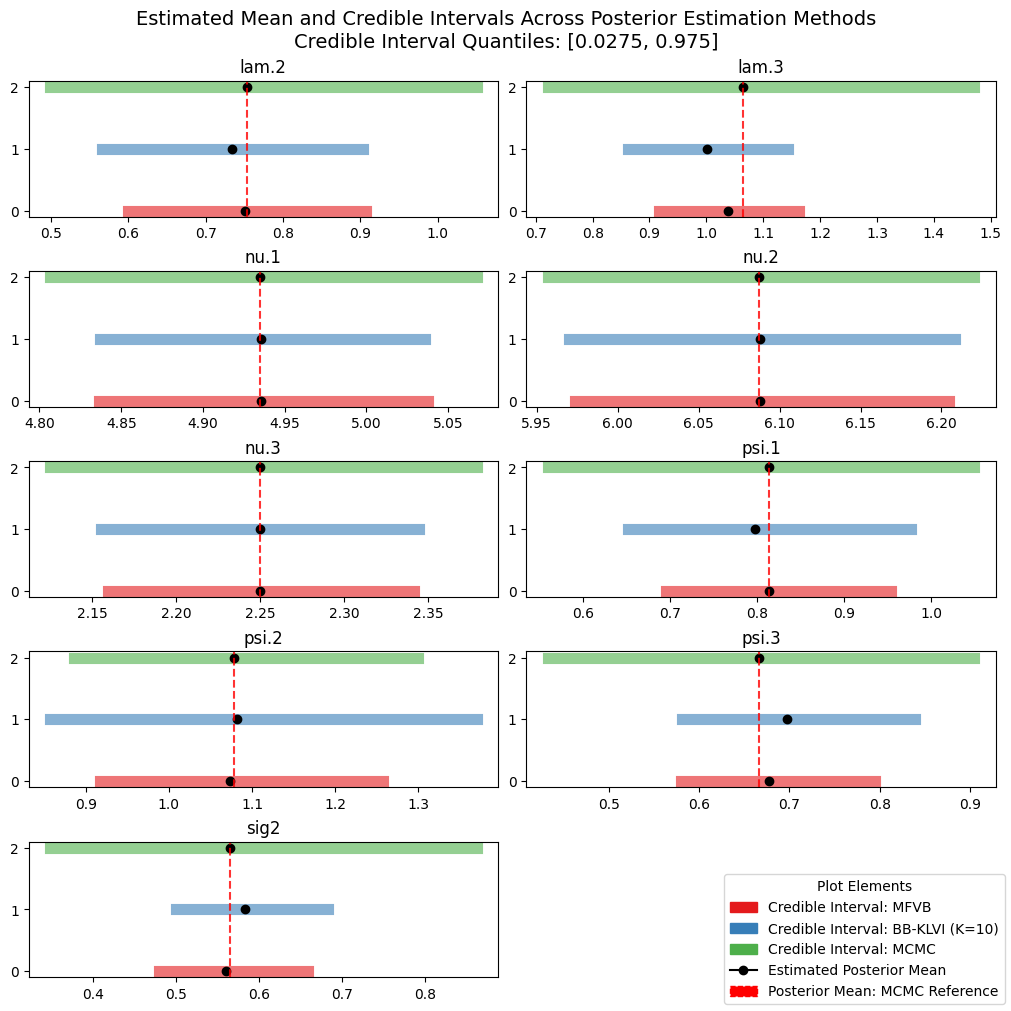

In [36]:
data = {
    'MFVB': mfvb_df, 
    'BB-KLVI (K=10)': klvi_df, 
    'MCMC': mcmc_df_nonlatent}

plot_credint(data)

# Non-Latent Parameter Visualisations

The $\eta_i, i = 1... n$ latent parameters represent the ability level of individual i: it cannot be observed or measured directly and is less useful for inference. It is described by the prior: $\eta_i | \sigma^2 \sim N(0, \sigma^2)$. 

If we plot MCMC means against $\eta_i$ means and MCMC variances against $\eta_i$ variances, we observe there is accurate estimate of posterior means but some misspecification of posterior variances.

In [21]:
from src.analysis.visualisation import plot_eta

In [27]:
ETA_VALUES = [f'eta.{i+1}' for i in range(y_data.shape[0])]
klvi_latent_df = sample_from_distribution({'eta': vi_model.qvar.qvar_by_var['eta'].dist()}, latent_only = False)
mcmc_latent_df = mcmc_df[ETA_VALUES]

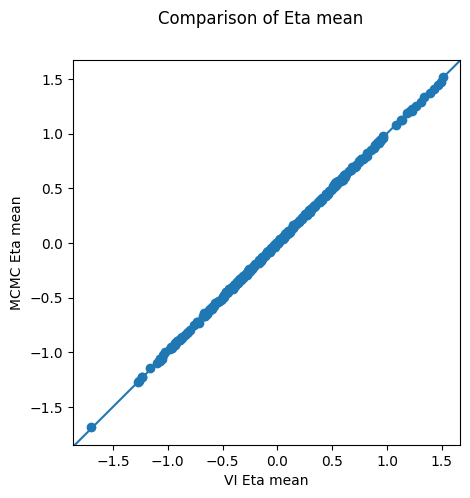

In [28]:
plot_eta(vidf = klvi_latent_df, mcmc_df= mcmc_latent_df, moment = 'mean')

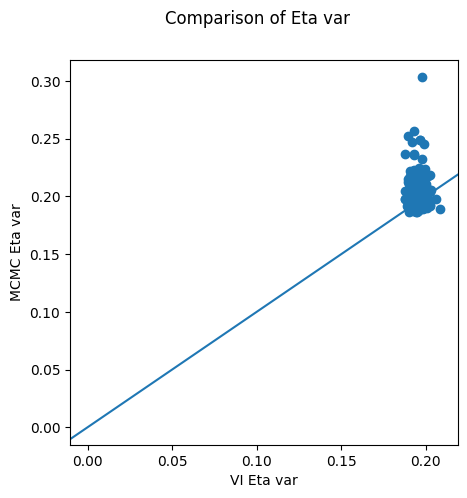

In [29]:
plot_eta(vidf = klvi_latent_df, mcmc_df = mcmc_latent_df, moment = 'var')

# Optimisation & Parameter Tuning 

We are performing multi-dimensional stochastic optimisation, so the choice of optimisation parameters is a non-trivial exercise. In this section I briefly review the design choices and rationale behind the most optimisation parameters.

More details can be found in Chapter 4 of my thesis.

## Optimal choice of K 

Recall that the loss function we seek to theoretically optimise is given by the expression 

$$
\text{ELBO} = \mathbb{E}_{q(\pmb{\theta})}\left[ \log {p(\mathbf{x} , \pmb{\theta})} - \log q(\pmb{\theta}) \right].
$$. 

The perform optimisation, we need to fix a value of K and any at any step t, we can only **estimate** the true loss function $\text{ELBO(q)}$ by the estimator given by: 

$$
\begin{align}
    &\hat{\text{VR}_{\alpha=1}} := \frac{1}{K}\sum_{i=1}^{i=K}\left[ 
    \log({{p(\mathbf{x}, \,  \pmb{\theta_i})}}) - \log({{q(\pmb{\theta_i})}})
    \right] \quad \pmb{\theta_i} \overset{iid}{\sim} q(\pmb{\theta})
\end{align}
$$

Many studies have suggested that $K =1$ is sufficient for performing black box VI. For the single factor model, however, I found that at least $K = 10$ is required to accurately match the results from analytical KLVI, in particular with regards to posterior mean estimation.

Furtermore, the intuition that increasing K increases the "accuracy" of black box KLVI is correct, in that for this model, as K increases, our results line up almost exactly with anlaytical KLVI. 

In [25]:
# vi_model_K1 = SingleCFAVIModel(y_data = y_data, hyper_params= hyper_params, degenerates={})
# vi_model_K1.optimize(optimisation_parameters= VI_OPTIMISATION_PARAMETERS, filename = 'tensorboard_runs/KLVI_Model', K = 1, alpha = 1)

 35%|███▍      | 6918/20000 [00:57<01:49, 119.45it/s]

VI converged at step t =  6918


In [ ]:
#Pickle and unpickling files 
#Pickle file 
filepath = VI_MODELS_FILEPATH
filename = 'KLVI_Model_K_1_alpha_1'
# pickle_file(filepath + filename, vi_model_K1)
vi_model_K1 = unpickle_file(filepath + filename)

In [31]:
klvi_K1_df = sample_from_distribution({var: qvar.dist() for var, qvar in vi_model_K1.qvar.qvar_by_var.items() if var!='eta'}, n = SAMPLE_SIZE)

In [ ]:
#create and pickle 
filename = "KLVI_Model_K_100_alpha_1"
vi_model_K100 = SingleCFAVIModel(y_data = y_data, hyper_params= hyper_params, degenerates={})
vi_model_K100.optimise(ooptimisation_parameters = VI_OPTIMISATION_PARAMETERS, filename = 'tensorboard_runs/KLVI_Model', K = 100, alpha = 1)
vi_model_K100= pickle_file(VI_MODELS_FILEPATH+filename, vi_model_K100)

#unpickle 
# vi_model_K100 = unpickle_file(filename)

In [ ]:
klvi_K100_df = sample_from_distribution({var: qvar.dist() for var, qvar in vi_model_K100.qvar.qvar_by_var.items() if var!='eta'}, n = SAMPLE_SIZE)

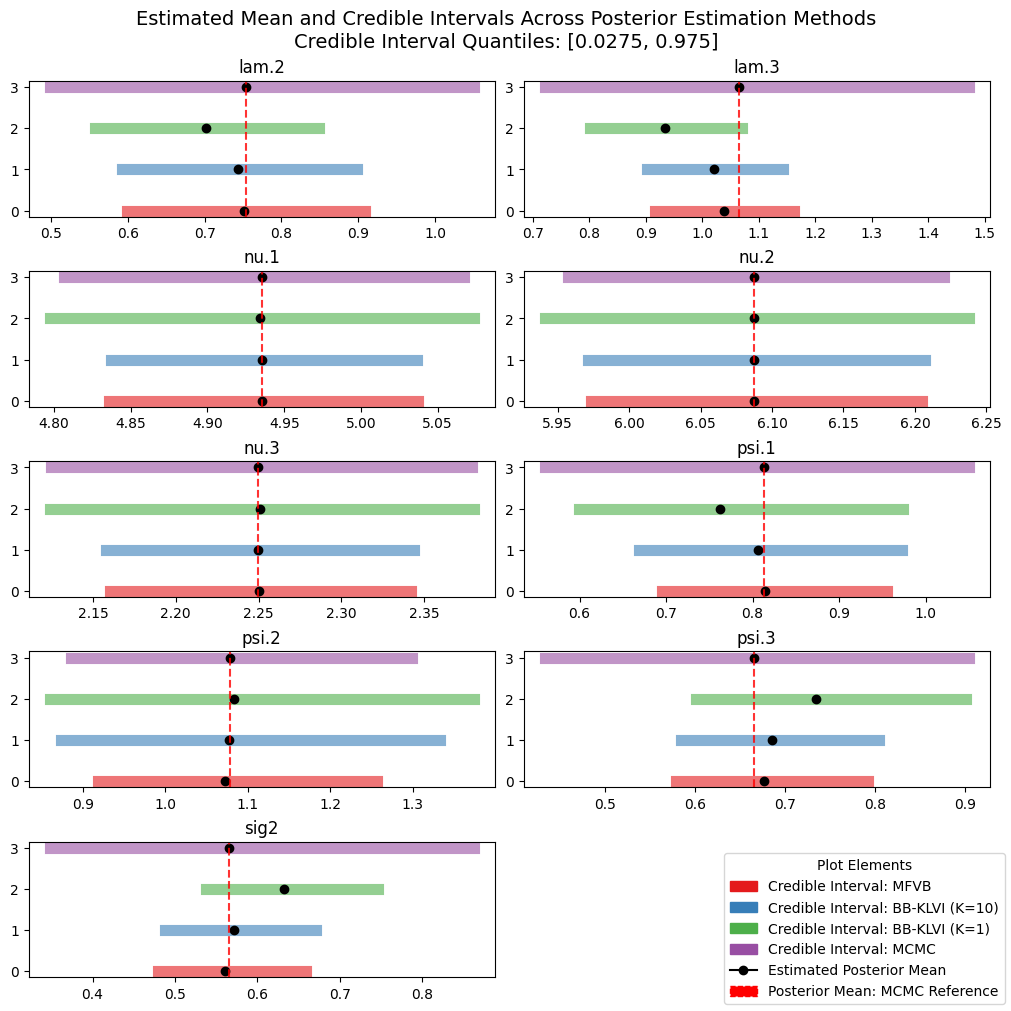

In [33]:
data = {
    'MFVB': mfvb_df, 
    'BB-KLVI (K=10)': klvi_df, 
    'BB-KLVI (K=1)': klvi_K1_df,
    # 'BB-KLVI (K = 100)': klvi_K100_df,
    'MCMC': mcmc_df_nonlatent}

plot_credint(data)

## The role of simulated data 

To assess different optimisation parameters, we used simulated data.

## Different learning rates for different parameter groupings 

By initially testing my ```VImodel``` implementation on simulated data, I am able to demonstrate that the nature of the single factor CFA model is such that larger learning rates are required for $\psi_j, \sigma^2$ compared to $\nu_j, \lambda_j$.

In [34]:
# Simulated Data

N = 300 
M = 3 
nu = torch.tensor([5.0, 6.0, 2.25])
sig2 = torch.tensor([0.565])
lam = torch.tensor([0.75, 1.05])
psi = torch.tensor([0.8, 1.10, 0.66])

#Generate Latent Parameter Values 
eta = torch.randn(N)*torch.sqrt(sig2)

#Concatenate lambda values 
lam1_fixed = torch.tensor([1.0])
lam_full = torch.cat((lam1_fixed, lam))

#Generate y values based on User Input
# yi ~ id Normal(nu + eta_i * lam, diag(psi)), yi /in R^m
#cov:
like_dist_cov = torch.diag(psi) #m*m tensor 
#means: want a n*m vector of means
like_dist_means = torch.matmul(eta.unsqueeze(1), lam_full.unsqueeze(0)) + nu

y_data_sim = mvn(like_dist_means, covariance_matrix= like_dist_cov).rsample() 

In [38]:
vi_model_sim = SingleCFAVIModel(y_data = y_data_sim, hyper_params= hyper_params, degenerates = {})

uniform_optimizer = torch.optim.Adam(
    [{'params': [vi_model_sim.qvar.qvar_by_var['nu'].var_params, vi_model_sim.qvar.qvar_by_var['lam'].var_params, vi_model_sim.qvar.qvar_by_var['eta'].var_params,], 'lr': 0.01},
    {'params': [vi_model_sim.qvar.qvar_by_var['psi'].var_params,  vi_model_sim.qvar.qvar_by_var['sig2'].var_params,], 'lr': 0.01},
    ]
)
vi_model_sim.optimize(optimisation_parameters= VI_OPTIMISATION_PARAMETERS, filename = 'tensorboard_runs/KLVI_Model_lr_0.01', K = 10, alpha = 1, optimizer = uniform_optimizer)

 69%|██████▉   | 13883/20000 [09:01<03:58, 25.65it/s]

VI converged at step t =  13883


In [ ]:
#Pickle and unpickling files 
filename = 'KLVI_Model_lr_0.01_K_10_alpha1'
#vi_model_sim = pickle_file(VI_MODELS_FILEPATH+filename, vi_model_sim)
vi_model_sim = unpickle_file(VI_MODELS_FILEPATH+filename)

In [37]:
%load_ext tensorboard
%tensorboard --logdir tensorboard_runs/KLVI_Model_lr_0.01_K_10_alpha1

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 2274), started 0:00:01 ago. (Use '!kill 2274' to kill it.)

Looking at the tensorboard runs, we can clearly see that although the loss function has converged and individual parameter values have converged, the individual inverse gamma parameters for $\sigma^2$ and $\psi$ seem to converge at a much slower rate and would thus benefit from a larger learning rate.

## Patience 

The MFVB algorithm stops iteration as soon as the relative error between successive loss function values is less than 0.01. 

However, since our loss function/gradient is stochastic, I have found that a patience of at least 100 consecutive iterations is required to properly hedge against random noise that results from using stochastic gradient estimators. In other words, we require the relative error to be beneath the given threshold for at least 100 iterations.

The same logic is applied to the learning rate scheduler, so the learning rate is decreased by a factor only once the decrease in the loss function becomes consistently small for 1,000 iterations. This is hard-coded in the SingleCFAVIModel. 

### Example 1 - Remove global patience threshold

To illustrate, consider an optimisation routine with no patience. 

In [45]:
vi_model_zero_patience = SingleCFAVIModel(y_data = y_data_sim, hyper_params= hyper_params, degenerates = {})
vi_model_zero_patience.optimize(optimisation_parameters= VIOptimisationParameters(num_iterations = 20_000, relative_error_threshold = 0.001, patience = 0), filename = 'tensoboard_runs/KLVI_Model_patience_0', K = 10, alpha = 1)

 34%|███▎      | 6733/20000 [04:26<08:44, 25.30it/s]

VI converged at step t =  6733


In [46]:
#Pickle and unpickling files 
filename = 'KLVI_Model_patience_0_K_10_alpha1'
pickle_file(VI_MODELS_FILEPATH+filename, vi_model_sim)
#vi_model_zero_patience= unpickle_file(VI_MODELS_FILEPATH+filename)

### Example 2 - Remove learning rate global patience threshold


In [71]:
### Example - Learning Rate Scheduler Patience Threshold

vi_model_zero_patience_scheduler = SingleCFAVIModel(y_data = y_data_sim, hyper_params= hyper_params, degenerates = {})
vi_model_zero_patience_scheduler.optimize(optimisation_parameters= VIOptimisationParameters(num_iterations = 20_000, relative_error_threshold = 0.001, patience = 0), filename = 'tensorboard_runs/KLVI_Model_patience_and_scheduler_0', K = 10, alpha = 1, scheduler_params= {
    'mode': 'min',
    'threshold_mode': 'rel',
    'factor': 0.1,
    'patience': 0, #Adjust the patience term
    'threshold': 0.0001,
    'cooldown': 0,
    'min_lr': 0.0,
    'eps': 1e-08,
})

  0%|          | 10/20000 [00:00<17:38, 18.89it/s]

VI converged at step t =  10


In [76]:
vi_model_zero_patience_scheduler.results.convergence_data.relative_errors

[tensor(3.1903),
 tensor(141.5344),
 tensor(1.5012),
 tensor(0.8269),
 tensor(0.5899),
 tensor(0.0462),
 tensor(0.0419),
 tensor(0.0033),
 tensor(0.0004)]

In [75]:
%load_ext tensorboard
%tensorboard --logdir tensorboard_runs/KLVI_Model_patience_and_scheduler_0_K_10_alpha1/

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6014 (pid 5717), started 0:00:02 ago. (Use '!kill 5717' to kill it.)

## How many backpropagations need to be performed? 

Calculating the gradient of the VR bound requires K backpropagations per optimisation step, which can be computationally costly. To speed up learning, it has been suggested to estimate the VR bound gradient with just one backpropagation per optimisation step. In the literature this is often termed the VR-single algorithm.